In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
pubg2 = pd.read_csv("pubg.csv")
pubg2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4444415 entries, 0 to 4444414
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [3]:
# correlation matrix
# features in type 'object' (Id, groupId, matchId, matchType) are dropped here
corr = pubg2.corr()

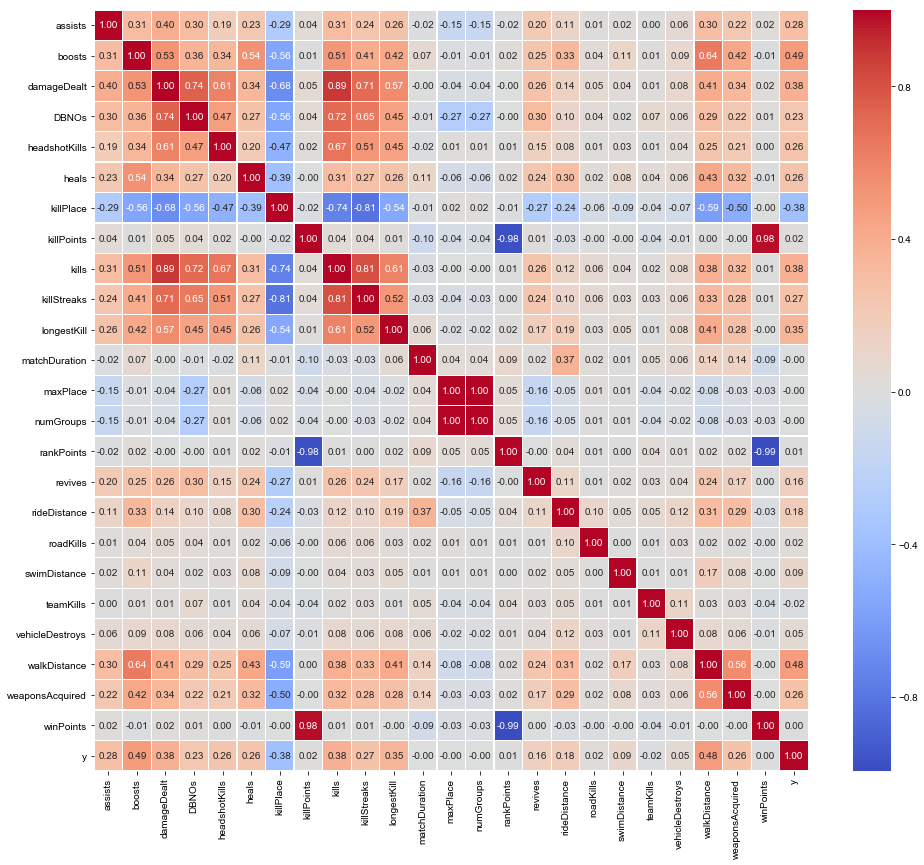

In [4]:
# plot the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=True, linewidths=.3, cmap='coolwarm', fmt='.2f')
sns.set(font_scale=1)
plt.show()

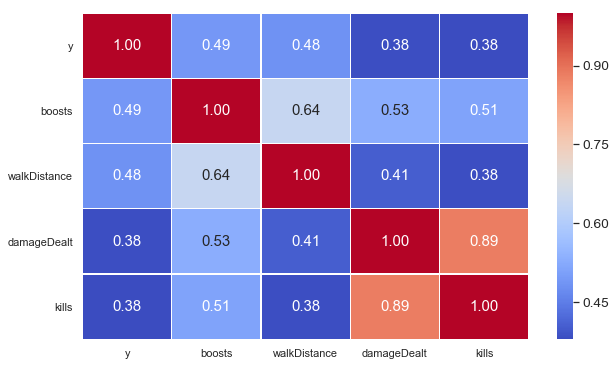

In [5]:
# let's see the heatmap for the 4 features that are most correlated with targat
f,ax = plt.subplots(figsize=(10, 6))
cols = corr.nlargest(5, 'y')['y'].index
cm = np.corrcoef(pubg2[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, annot=True, linewidths=.3, cmap='coolwarm', fmt='.2f',yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We decided to not use PCA here because using PCA will decrease the interpretability of our model, while our goal is to find out what behaviours can giva us higher chance of win.

### Feature Engineering

Based on our game experience, we think there are some hidden features in the data that are correlated with our target and some features can be combined to be more meaningful.

1) As there is no guarantee of there being 100 players per match, some features are not compareable in match of different sizes (i.e. kills, it's easier to meet and kill someone in a match of size 100 than of size 80), so it's meaningful to normalize these features based on number of players in the match.

In [6]:
# create a new feature for number of players in a match
pubg2['numPlayers'] = pubg2.groupby('matchId')['matchId'].transform('count')
pubg2.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,y,numPlayers
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.0,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.5,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.0,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.9,0,0,0,75,...,0.0000,0,0.00,0,0,202.80,3,0,0,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.0,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0,97


We want to normalize the following features:

damageDealt - Total damage dealt. 

matchDuration - Duration of match in seconds.

maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

kills - Number of enemy players killed.

In [7]:
pubg2['damageDealtN'] = pubg2['damageDealt']*((100-pubg2['numPlayers'])/100 + 1)
pubg2['matchDurationN'] = pubg2['matchDuration']*((100-pubg2['numPlayers'])/100 + 1)
pubg2['maxPlaceN'] = pubg2['maxPlace']*((100-pubg2['numPlayers'])/100 + 1)
pubg2['killsN'] = pubg2['kills']*((100-pubg2['numPlayers'])/100 + 1)
pubg2[['numPlayers','damageDealt','damageDealtN', 'matchDuration','matchDurationN', 'maxPlace', 'maxPlaceN', 'kills', 'killsN']].head()

,numPlayers,damageDealt,damageDealtN,matchDuration,matchDurationN,maxPlace,maxPlaceN,kills,killsN
0,96,0.0,0.000,1306,1358.24,28,29.12,0,0.00
1,91,91.5,99.735,1777,1936.93,26,28.34,0,0.00
2,98,68.0,69.360,1318,1344.36,50,51.00,0,0.00
3,91,32.9,35.861,1436,1565.24,31,33.79,0,0.00
4,97,100.0,103.000,1424,1466.72,97,99.91,1,1.03


In [8]:
pubg2 = pubg2.drop(columns = ['numPlayers','damageDealt', 'matchDuration', 'maxPlace', 'kills'])

(2) Some features can be combined

In [9]:
pubg2['items'] = pubg2['heals'] + pubg2['boosts']
pubg2['total_distance'] = pubg2['rideDistance'] + pubg2['swimDistance'] + pubg2['walkDistance']
pubg2[['heals','boosts', 'items','rideDistance', 'swimDistance', 'walkDistance','total_distance']].head()

,heals,boosts,items,rideDistance,swimDistance,walkDistance,total_distance
0,0,0,0,0.0000,0.00,244.80,244.8000
1,0,0,0,0.0045,11.04,1434.00,1445.0445
2,0,0,0,0.0000,0.00,161.80,161.8000
3,0,0,0,0.0000,0.00,202.80,202.8000
4,0,0,0,0.0000,0.00,49.75,49.7500


In [10]:
pubg2[['heals','boosts', 'items','rideDistance', 'swimDistance', 'walkDistance','total_distance']].head()
# pubg2 = pubg2.drop(columns = ['heals','boosts', 'rideDistance', 'swimDistance', 'walkDistance'])

,heals,boosts,items,rideDistance,swimDistance,walkDistance,total_distance
0,0,0,0,0.0000,0.00,244.80,244.8000
1,0,0,0,0.0045,11.04,1434.00,1445.0445
2,0,0,0,0.0000,0.00,161.80,161.8000
3,0,0,0,0.0000,0.00,202.80,202.8000
4,0,0,0,0.0000,0.00,49.75,49.7500


In [11]:
# solo = pubg2.loc[pubg2['matchType'].str.contains('solo')]
# pd.unique(solo['matchType'])

In [12]:
# duo = pubg2.loc[pubg2['matchType'].str.contains('duo')]
# pd.unique(duo['matchType'])

In [13]:
# squad = pubg2.loc[pubg2['matchType'].str.contains('squad')]
# pd.unique(squad['matchType'])

In [14]:
# drop features of type object
# solo = solo.drop(columns = ['Id', 'groupId', 'matchId', 'matchType'])
# duo = duo.drop(columns = ['Id', 'groupId', 'matchId', 'matchType'])
# squad = squad.drop(columns = ['Id', 'groupId', 'matchId', 'matchType'])
# pubg2 = pubg2.drop(columns = ['Id', 'groupId', 'matchId', 'matchType'])

### Train-test split

In [87]:
from sklearn.model_selection import train_test_split
# for the model of all match type
data = pubg2.copy().drop(columns = ['Id', 'groupId', 'matchId'])
train = data.sample(frac = 0.7, random_state = 0)
test = data.drop(train.index)
# further split for validation
validation = train.sample(frac = 0.3, random_state = 0)
train = train.drop(validation.index)
modelVal = test.sample(frac = 0.3, random_state = 0)
test = test.drop(modelVal.index)

### Split based on match type

We think the importance features might be different for different match types. 

Before doing feature selection, we will split the data based on match type first. 

In [11]:
# for model of solo
solo_train = train.loc[train['matchType'].str.contains('solo')].drop(columns = 'matchType')
solo_test = test.loc[test['matchType'].str.contains('solo')].drop(columns = 'matchType')
solo_val = validation.loc[validation['matchType'].str.contains('solo')].drop(columns = 'matchType')
solo_modelVal = modelVal.loc[modelVal['matchType'].str.contains('solo')].drop(columns = 'matchType')

In [12]:
# for model of duo
duo_train = train.loc[train['matchType'].str.contains('duo')].drop(columns = 'matchType')
duo_test = test.loc[test['matchType'].str.contains('duo')].drop(columns = 'matchType')
duo_val = validation.loc[validation['matchType'].str.contains('duo')].drop(columns = 'matchType')
duo_modelVal = modelVal.loc[modelVal['matchType'].str.contains('duo')].drop(columns = 'matchType')

In [13]:
# for model of squad
squad_train = train.loc[train['matchType'].str.contains('squad')].drop(columns = 'matchType')
squad_test = test.loc[test['matchType'].str.contains('squad')].drop(columns = 'matchType')
squad_val = validation.loc[validation['matchType'].str.contains('squad')].drop(columns = 'matchType')
squad_modelVal = modelVal.loc[modelVal['matchType'].str.contains('squad')].drop(columns = 'matchType')

In [88]:
# for model regrardless of dorm type
train = train.drop(columns = 'matchType')
test = test.drop(columns = 'matchType')
validation = validation.drop(columns = 'matchType')
modelVal = modelVal.drop(columns = 'matchType')

# Penalty Logistic Regression

## Solo Data

Ref for below: https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

In [40]:
# grid searching key hyperparametres for logistic regression
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import imblearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Standard Scale: 

In [32]:
scaler = StandardScaler()

solo_xTrain2 = solo_train.copy().drop(columns ='y')
solo_yTrain2 = solo_train['y']
solo_xTest2 = solo_test.copy().drop(columns ='y')
solo_yTest2 = solo_test['y']
solo_xVal2 = solo_val.copy().drop(columns ='y')
solo_yVal2 = solo_val['y']

scaler.fit(solo_xTrain2)
solo_xTrain2 = scaler.transform(solo_xTrain2)
solo_xVal2 = scaler.transform(solo_xVal2)
solo_xTest2 = scaler.transform(solo_xTest2)

 A test model without balancing dataset

In [34]:
solo_clf2 = LogisticRegression(penalty = 'none')
solo_clf2.fit(solo_xTrain2, solo_yTrain2)
yHat = solo_clf2.predict(solo_xVal2)
# print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(solo_clf2.f1_score(solo_xTest2, solo_yTest2)))
print('F1 of logistic regression classifier on test set: {:.2f}'.format(f1_score(solo_yVal2, yHat)))

Accuracy of logistic regression classifier on test set: 0.61


### Grid Search
It is notable that the above models were run with the default parameters determined by the LogisticRegression modules. Could we improve the model by tuning the hyperparameters of the model?
To achieve this, we define a “grid” of parameters that we would want to test out in the model and select the best model using GridSearchCV.

#### Solver options:
newton-cg -- A newton method. Newton methods use an exact Hessian matrix. It's slow for large datasets, because it computes the second derivatives. \
lbfgs — Stands for Limited-memory Broyden–Fletcher–Goldfarb–Shanno. It approximates the second derivative matrix updates with gradient evaluations. It stores only the last few updates, so it saves memory. It isn't super fast with large data sets. It will be the default solver as of Scikit-learn version 0.22.0.\
liblinear — Library for Large Linear Classification. Uses a coordinate descent algorithm. Coordinate descent is based on minimizing a multivariate function by solving univariate optimization problems in a loop. In other words, it moves toward the minimum in one direction at a time. It is the default solver for Scikit-learn versions earlier than 0.22.0. It performs pretty well with high dimensionality. It does have a number of drawbacks. It can get stuck, is unable to run in parallel, and can only solve multi-class logistic regression with one-vs.-rest.\
sag — Stochastic Average Gradient descent. A variation of gradient descent and incremental aggregated gradient approaches that uses a random sample of previous gradient values. Fast for big datasets.
saga — Extension of sag that also allows for L1 regularization. Should generally train faster than sag.\
Ref: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451

![title](https://miro.medium.com/proxy/1*u35QBoGx3thqrSLXcpMJWQ.png)

In [35]:
solo_trainRF = solo_train.sample(n = 50000)
solo_xTrain3 = solo_trainRF.copy().drop(columns ='y')
solo_yTrain3 = solo_trainRF['y']

solo_xVal3 = solo_val.copy().drop(columns ='y')
solo_yVal3 = solo_val['y']

scaler = StandardScaler()
scaler.fit(solo_xTrain3)
solo_xTrain3 = scaler.transform(solo_xTrain3)
solo_xVal3 = scaler.transform(solo_xVal3)

In [36]:
# define dataset: solo_xTrain, solo_yTrain
# define models and parameters
model = LogisticRegression()
solvers = ['lbfgs', 'sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=1, cv=cv, 
                           verbose = 15, scoring='f1',error_score=0)
grid_result = grid_search.fit(solo_xTrain3, solo_yTrain3)


Fitting 30 folds for each of 15 candidates, totalling 450 fits
[CV] C=100, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.610, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.659, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.607, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.649, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.614, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s


[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.615, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.615, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.4s remaining:    0.0s


[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.572, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.604, total=   0.1s
[CV] C=100, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.7s remaining:    0.0s


[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.590, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.616, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.1s remaining:    0.0s


[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.630, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.604, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.5s remaining:    0.0s


[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.644, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.7s remaining:    0.0s


[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.638, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.616, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.594, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.600, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.587, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.612, total=   0.3s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.574, total=   0.2s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] .

/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.607, total=   2.0s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.658, total=   1.4s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.605, total=   1.5s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.649, total=   2.1s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.614, total=   2.2s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.614, total=   2.0s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.613, total=   1.4s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.572, total=   1.5s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.603, total=   1.5s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.590, total=   1.5s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.616, total=   1.4s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.632, total=   1.6s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.601, total=   1.7s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.645, total=   1.6s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.637, total=   1.9s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.612, total=   2.0s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.595, total=   2.0s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.601, total=   2.4s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.587, total=   1.9s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.616, total=   2.0s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.576, total=   2.2s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.597, total=   2.2s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.611, total=   2.0s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.662, total=   2.2s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.587, total=   2.3s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.590, total=   2.1s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.644, total=   1.8s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.611, total=   2.0s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.613, total=   1.8s
[CV] C=100, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=100, penalty=l2, solver=sag, score=0.626, total=   1.6s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.611, total=   1.9s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.656, total=   1.8s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.601, total=   1.6s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.656, total=   1.5s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.610, total=   1.4s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.615, total=   1.3s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.615, total=   1.5s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.571, total=   2.0s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.599, total=   1.8s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.591, total=   1.9s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.613, total=   1.6s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.636, total=   1.8s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.602, total=   1.7s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.646, total=   1.8s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.631, total=   1.7s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.611, total=   1.9s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.596, total=   1.9s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.599, total=   1.8s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.586, total=   1.4s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.612, total=   1.8s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.572, total=   1.8s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.601, total=   2.1s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.612, total=   2.2s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.657, total=   1.9s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.588, total=   2.0s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.590, total=   2.0s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.645, total=   1.5s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.613, total=   1.4s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.611, total=   1.4s
[CV] C=100, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=100, penalty=l2, solver=saga, score=0.628, total=   1.4s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ...... C=10, penalty=l2, solver=lbfgs, score=0.610, total=   0.1s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ...... C=10, penalty=l2, solver=lbfgs, score=0.659, total=   0.2s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ...... C=10, penalty=l2, solver=lbfgs, score=0.607, total=   0.1s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ...... C=10, penalty=l2, solver=lbfgs, score=0.649, total=   0.2s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ...... C=10, penalty=l2, solver=lbfgs, score=0.613, total=   0.1s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ...... C=10, penalty=l2, solver=lbfgs, score=0.615, total=   0.2s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] .

/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.607, total=   1.9s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.658, total=   1.8s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.605, total=   1.8s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.649, total=   2.0s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.613, total=   1.7s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.614, total=   2.0s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.613, total=   1.6s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.573, total=   2.3s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.603, total=   2.1s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.590, total=   1.8s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.616, total=   1.9s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.632, total=   2.0s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.601, total=   2.0s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.647, total=   1.6s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.637, total=   2.0s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.612, total=   1.8s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.595, total=   1.9s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.601, total=   1.9s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.587, total=   1.9s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.616, total=   1.8s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.576, total=   1.5s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.597, total=   1.6s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.611, total=   1.6s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.662, total=   1.6s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.587, total=   1.8s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.590, total=   1.8s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.644, total=   1.4s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.611, total=   1.6s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.613, total=   1.7s
[CV] C=10, penalty=l2, solver=sag ....................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........ C=10, penalty=l2, solver=sag, score=0.626, total=   1.7s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.611, total=   1.4s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.656, total=   1.3s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.601, total=   1.4s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.656, total=   1.4s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.609, total=   1.4s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.615, total=   1.3s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.615, total=   1.3s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.571, total=   1.6s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.599, total=   1.6s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.591, total=   1.6s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.613, total=   1.8s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.636, total=   1.8s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.602, total=   1.6s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.646, total=   1.5s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.631, total=   2.1s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.611, total=   1.9s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.596, total=   2.1s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.599, total=   1.7s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.586, total=   1.6s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.612, total=   1.5s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.572, total=   1.5s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.601, total=   1.7s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.612, total=   2.2s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.657, total=   2.0s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.588, total=   1.8s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.589, total=   1.7s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.645, total=   2.0s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.613, total=   1.5s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.611, total=   1.8s
[CV] C=10, penalty=l2, solver=saga ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=10, penalty=l2, solver=saga, score=0.628, total=   2.1s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.609, total=   0.2s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.658, total=   0.2s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.606, total=   0.2s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.648, total=   0.2s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.614, total=   0.2s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.614, total=   0.2s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] .

/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.608, total=   1.6s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.659, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.605, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.652, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.611, total=   1.8s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.612, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.612, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.574, total=   1.8s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.600, total=   1.8s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.589, total=   1.6s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.616, total=   1.3s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.632, total=   1.6s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.601, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.648, total=   1.4s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.632, total=   1.6s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.611, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.593, total=   1.4s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.602, total=   1.5s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.586, total=   1.6s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.613, total=   1.9s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.574, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.599, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.610, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.662, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.589, total=   1.6s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.592, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.642, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.611, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.614, total=   1.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.626, total=   1.9s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.611, total=   1.8s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.656, total=   1.7s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.601, total=   1.9s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.657, total=   1.6s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.609, total=   1.7s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.615, total=   1.8s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.615, total=   1.5s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.571, total=   1.6s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.599, total=   1.9s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.593, total=   1.8s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.614, total=   1.9s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.636, total=   1.8s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.599, total=   1.8s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.646, total=   1.6s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.631, total=   1.7s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.611, total=   1.3s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.596, total=   1.5s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.599, total=   1.6s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.584, total=   1.7s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.611, total=   1.6s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.572, total=   1.4s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.604, total=   1.3s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.613, total=   1.2s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.657, total=   1.2s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.587, total=   1.2s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.586, total=   1.4s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.644, total=   1.3s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.613, total=   1.3s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.611, total=   1.3s
[CV] C=1.0, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.628, total=   1.3s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] ..... C=0.1, penalty=l2, solver=lbfgs, score=0.604, total=   0.1s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] ..... C=0.1, penalty=l2, solver=lbfgs, score=0.655, total=   0.1s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] ..... C=0.1, penalty=l2, solver=lbfgs, score=0.599, total=   0.1s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] ..... C=0.1, penalty=l2, solver=lbfgs, score=0.663, total=   0.1s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] ..... C=0.1, penalty=l2, solver=lbfgs, score=0.608, total=   0.1s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] ..... C=0.1, penalty=l2, solver=lbfgs, score=0.615, total=   0.1s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] .

/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.604, total=   1.4s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.655, total=   1.4s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.599, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.663, total=   1.4s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.609, total=   1.5s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.615, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.610, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.570, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.600, total=   1.4s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.595, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.614, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.638, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.598, total=   1.4s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.644, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.630, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.612, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.590, total=   1.4s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.599, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.588, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.607, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.570, total=   1.5s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.602, total=   1.4s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.616, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.653, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.586, total=   1.4s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.583, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.649, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.609, total=   1.3s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.608, total=   1.4s
[CV] C=0.1, penalty=l2, solver=sag ...................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.626, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.606, total=   1.2s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.651, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.598, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.664, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.608, total=   1.2s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.618, total=   1.2s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.611, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.571, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.597, total=   1.2s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.594, total=   1.2s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.614, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.636, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.598, total=   1.2s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.644, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.628, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.613, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.589, total=   1.2s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.600, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.589, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.606, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.571, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.605, total=   1.4s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.618, total=   1.5s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.653, total=   1.5s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.589, total=   1.6s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.584, total=   1.6s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.649, total=   1.4s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.606, total=   1.4s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.609, total=   1.3s
[CV] C=0.1, penalty=l2, solver=saga ..................................


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.627, total=   1.3s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.01, penalty=l2, solver=lbfgs, score=0.593, total=   0.1s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.01, penalty=l2, solver=lbfgs, score=0.621, total=   0.1s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.01, penalty=l2, solver=lbfgs, score=0.596, total=   0.1s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.01, penalty=l2, solver=lbfgs, score=0.668, total=   0.1s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.01, penalty=l2, solver=lbfgs, score=0.602, total=   0.1s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.01, penalty=l2, solver=lbfgs, score=0.596, total=   0.1s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .

[CV] ...... C=0.01, penalty=l2, solver=sag, score=0.594, total=   0.3s
[CV] C=0.01, penalty=l2, solver=sag ..................................
[CV] ...... C=0.01, penalty=l2, solver=sag, score=0.599, total=   0.4s
[CV] C=0.01, penalty=l2, solver=sag ..................................
[CV] ...... C=0.01, penalty=l2, solver=sag, score=0.613, total=   0.3s
[CV] C=0.01, penalty=l2, solver=saga .................................
[CV] ..... C=0.01, penalty=l2, solver=saga, score=0.593, total=   0.7s
[CV] C=0.01, penalty=l2, solver=saga .................................
[CV] ..... C=0.01, penalty=l2, solver=saga, score=0.621, total=   0.7s
[CV] C=0.01, penalty=l2, solver=saga .................................
[CV] ..... C=0.01, penalty=l2, solver=saga, score=0.596, total=   0.6s
[CV] C=0.01, penalty=l2, solver=saga .................................
[CV] ..... C=0.01, penalty=l2, solver=saga, score=0.668, total=   0.7s
[CV] C=0.01, penalty=l2, solver=saga .................................
[CV] .

[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  7.4min finished


In [37]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.613427 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.613427 (0.022786) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.612774 (0.022614) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.612613 (0.022871) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.613220 (0.022803) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.612825 (0.022590) with: {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.612510 (0.022930) with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.612798 (0.022636) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.612503 (0.022760) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}
0.612433 (0.023142) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
0.611263 (0.023870) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.611440 (0.023804) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
0.611569 (0.023389) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
0.603430 (0.022110) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs

In [38]:
grid_result.best_estimator_

LogisticRegression(C=100)

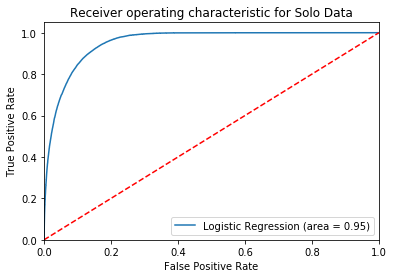

In [70]:
solo_best_estimator = grid_result.best_estimator_
estimator = solo_best_estimator
y_pred = estimator.predict_proba(solo_xVal3)
logit_roc_auc = roc_auc_score(solo_yVal3, y_pred[:,1])
fpr, tpr, thresholds = roc_curve(solo_yVal3, estimator.predict_proba(solo_xVal3)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Solo Data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [83]:
solo_best_estimator = grid_result.best_estimator_
solo_best_estimator.fit(solo_xTrain2,solo_yTrain2)
yHat = solo_best_estimator.predict(solo_xVal2)
print('Imbalanced accuracy of logistic regression classifier on validation set: {:.2f}'.format(solo_best_estimator.score(solo_xVal2, solo_yVal2)))
print('F1 of logistic regression classifier on validation set: {:.2f}'.format(f1_score(solo_yVal2, yHat)))

Imbalanced accuracy of logistic regression classifier on validation set: 0.93
F1 of logistic regression classifier on validation set: 0.62


Text(0.5, 1.0, '2-class Precision-Recall curve for Solo data: ')

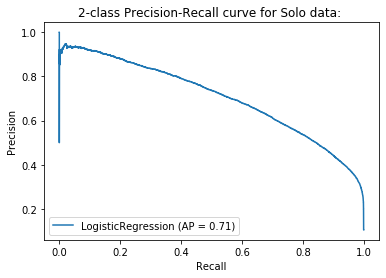

In [71]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(solo_best_estimator, solo_xVal2, solo_yVal2)
disp.ax_.set_title('2-class Precision-Recall curve for Solo data: ')

### Evaluate Model Performance on Model Validation Data 

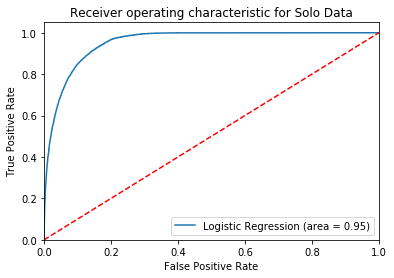

Accuracy of logistic regression classifier on validation set: 0.93
F1 of logistic regression classifier on validation set: 0.62


Text(0.5, 1.0, '2-class Precision-Recall curve for Solo data: ')

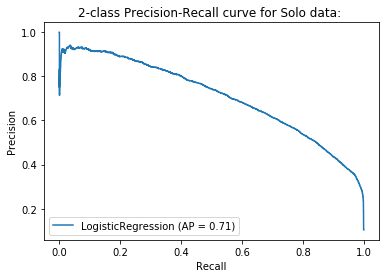

In [84]:
scaler = StandardScaler()

solo_xTrain2 = solo_train.copy().drop(columns ='y')
solo_yTrain2 = solo_train['y']
solo_xmodelVal = solo_modelVal.copy().drop(columns ='y')
solo_ymodelVal = solo_modelVal['y']

scaler.fit(solo_xTrain2)
solo_xTrain2 = scaler.transform(solo_xTrain2)
solo_xmodelVal = scaler.transform(solo_xmodelVal)

solo_best_estimator = grid_result.best_estimator_
estimator = solo_best_estimator
y_pred = estimator.predict_proba(solo_xmodelVal)
logit_roc_auc = roc_auc_score(solo_ymodelVal, y_pred[:,1])
fpr, tpr, thresholds = roc_curve(solo_ymodelVal, estimator.predict_proba(solo_xmodelVal)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Solo Data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

solo_best_estimator = grid_result.best_estimator_
solo_best_estimator.fit(solo_xTrain2,solo_yTrain2)
yHat = solo_best_estimator.predict(solo_xmodelVal)
print('Accuracy of logistic regression classifier on validation \
set: {:.2f}'.format(solo_best_estimator.score(solo_xmodelVal, solo_ymodelVal)))
print('F1 of logistic regression classifier on model validation set: {:.2f}'.format(f1_score(solo_ymodelVal, yHat)))

disp = plot_precision_recall_curve(solo_best_estimator, solo_xmodelVal, solo_ymodelVal)
disp.ax_.set_title('2-class Precision-Recall curve for Solo data: ')

### Duo Data

Standard Scale

In [44]:
scaler = StandardScaler()

duo_xTrain2 = duo_train.copy().drop(columns ='y')
duo_yTrain2 = duo_train['y']
duo_xTest2 = duo_test.copy().drop(columns ='y')
duo_yTest2 = duo_test['y']
duo_xVal2 = duo_val.copy().drop(columns ='y')
duo_yVal2 = duo_val['y']

scaler.fit(duo_xTrain2)
duo_xTrain2 = scaler.transform(duo_xTrain2)
duo_xTest2 = scaler.transform(duo_xTest2)
duo_xVal2 = scaler.transform(duo_xVal2)

In [45]:
# define dataset: duo_xTrain2_res, duo_yTrain2_res
# define models and parameters
model = LogisticRegression()
solvers = ['lbfgs', 'sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid,
                           n_jobs=-1, cv=cv, verbose = 15, 
                           scoring='f1',error_score=0)
grid_result = grid_search.fit(duo_xTrain2, duo_yTrain2)

Fitting 30 folds for each of 15 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed: 10.0min
[Paralle

[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed: 18.0min
[Paralle

[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 415 tasks      | elapsed: 26.5min
[Paralle

In [46]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, 
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.598084 using {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
0.598071 (0.004553) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.598032 (0.004408) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.598071 (0.004459) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.598064 (0.004528) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.598032 (0.004429) with: {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.598077 (0.004456) with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.598053 (0.004535) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.598057 (0.004406) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}
0.598084 (0.004484) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
0.597998 (0.004412) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.598010 (0.004395) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
0.598037 (0.004441) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
0.597187 (0.004535) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'

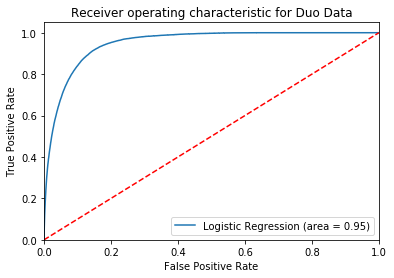

In [47]:
estimator = grid_result.best_estimator_
y_pred = estimator.predict_proba(duo_xVal2)
logit_roc_auc = roc_auc_score(duo_yVal2, y_pred[:,1])
fpr, tpr, thresholds = roc_curve(duo_yVal2, estimator.predict_proba(duo_xVal2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Duo Data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [82]:
# duo_best_estimator = LogisticRegression(penalty = 'l2', C = 0.01, solver = 'lbfgs')
# duo_best_estimator.fit(duo_xTrain2_res,duo_yTrain2_res)
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(duo_best_estimator.score(duo_xVal2, duo_yVal2)))


Accuracy of logistic regression classifier on validation set: 0.93


In [48]:
duo_best_estimator = grid_result.best_estimator_
duo_best_estimator.fit(duo_xTrain2,duo_yTrain2)
yHat = duo_best_estimator.predict(duo_xVal2)
print('F1 of logistic regression classifier on validation set: {:.2f}'.format(f1_score(duo_yVal2, yHat)))

F1 of logistic regression classifier on validation set: 0.60


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Text(0.5, 1.0, '2-class Precision-Recall curve for Duo data: ')

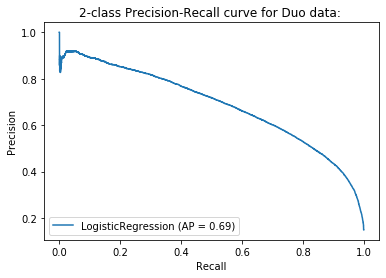

In [73]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(duo_best_estimator, duo_xVal2, duo_yVal2)
disp.ax_.set_title('2-class Precision-Recall curve for Duo data: ')

### Evaluate Model Performance on Model Validation Data 

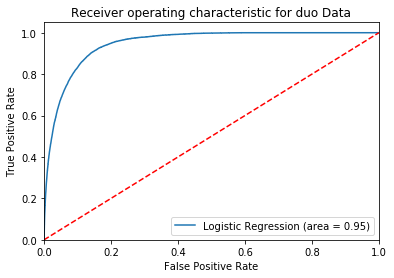

Accuracy of logistic regression classifier on validation set: 0.93
F1 of logistic regression classifier on model validation set: 0.60


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Text(0.5, 1.0, '2-class Precision-Recall curve for duo data: ')

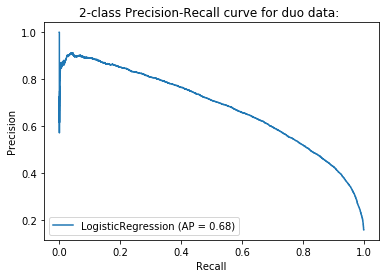

In [85]:
scaler = StandardScaler()

duo_xTrain2 = duo_train.copy().drop(columns ='y')
duo_yTrain2 = duo_train['y']
duo_xmodelVal = duo_modelVal.copy().drop(columns ='y')
duo_ymodelVal = duo_modelVal['y']

scaler.fit(duo_xTrain2)
duo_xTrain2 = scaler.transform(duo_xTrain2)
duo_xmodelVal = scaler.transform(duo_xmodelVal)

duo_best_estimator = grid_result.best_estimator_
estimator = duo_best_estimator
y_pred = estimator.predict_proba(duo_xmodelVal)
logit_roc_auc = roc_auc_score(duo_ymodelVal, y_pred[:,1])
fpr, tpr, thresholds = roc_curve(duo_ymodelVal, estimator.predict_proba(duo_xmodelVal)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for duo Data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

duo_best_estimator = grid_result.best_estimator_
duo_best_estimator.fit(duo_xTrain2,duo_yTrain2)
yHat = duo_best_estimator.predict(duo_xmodelVal)
print('Accuracy of logistic regression classifier on validation \
set: {:.2f}'.format(duo_best_estimator.score(duo_xmodelVal, duo_ymodelVal)))
print('F1 of logistic regression classifier on model validation set: {:.2f}'.format(f1_score(duo_ymodelVal, yHat)))

disp = plot_precision_recall_curve(duo_best_estimator, duo_xmodelVal, duo_ymodelVal)
disp.ax_.set_title('2-class Precision-Recall curve for duo data: ')

### Squad Data

Standard Scale

In [49]:
scaler = StandardScaler()

squad_xTrain2 = squad_train.copy().drop(columns ='y')
squad_yTrain2 = squad_train['y']
squad_xTest2 = squad_test.copy().drop(columns ='y')
squad_yTest2 = squad_test['y']
squad_xVal2 = squad_val.copy().drop(columns ='y')
squad_yVal2 = squad_val['y']

scaler.fit(squad_xTrain2)
squad_xTrain2 = scaler.transform(squad_xTrain2)
squad_xTest2 = scaler.transform(squad_xTest2)
squad_xVal2 = scaler.transform(squad_xVal2)

In [50]:
# define dataset: squad_xTrain2_res, squad_yTrain2_res
# define models and parameters
model = LogisticRegression()
solvers = ['lbfgs', 'sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid,
                           n_jobs=-1, cv=cv, verbose = 5, 
                           scoring='f1',error_score=0)
grid_result = grid_search.fit(squad_xTrain2, squad_yTrain2)

Fitting 30 folds for each of 15 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 41.5min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 45.0min finished
/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [51]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, 
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.516627 using {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
0.516573 (0.003473) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.516584 (0.003482) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.516606 (0.003443) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.516586 (0.003477) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.516587 (0.003474) with: {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.516610 (0.003452) with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.516579 (0.003479) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.516586 (0.003463) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}
0.516596 (0.003465) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
0.516572 (0.003450) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.516588 (0.003462) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
0.516627 (0.003462) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
0.516104 (0.003247) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'

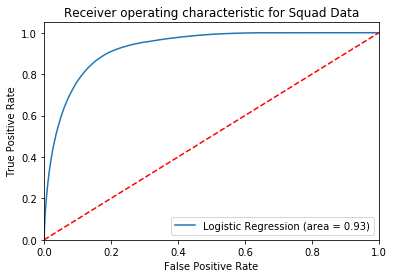

In [52]:
estimator = grid_result.best_estimator_
y_pred = estimator.predict_proba(squad_xVal2)
logit_roc_auc = roc_auc_score(squad_yVal2, y_pred[:,1])
fpr, tpr, thresholds = roc_curve(squad_yVal2, estimator.predict_proba(squad_xVal2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Squad Data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [129]:
# squad_best_estimator = LogisticRegression(penalty = 'l2', C = 0.01, solver = 'sag')
# squad_best_estimator.fit(squad_xTrain2_res,squad_yTrain2_res)
# print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(squad_best_estimator.score(squad_xTest2, squad_yTest2)))


Accuracy of logistic regression classifier on test set: 0.84


In [53]:
squad_best_estimator = grid_result.best_estimator_
squad_best_estimator.fit(squad_xTrain2,squad_yTrain2)
yHat = squad_best_estimator.predict(squad_xVal2)
print('F1 of logistic regression classifier on validation set: {:.2f}'.format(f1_score(squad_yVal2, yHat)))

F1 of logistic regression classifier on validation set: 0.52


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [80]:
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(squad_best_estimator.score(squad_xVal2, squad_yVal2)))

Accuracy of logistic regression classifier on validation set: 0.92


Text(0.5, 1.0, '2-class Precision-Recall curve for Squad data: ')

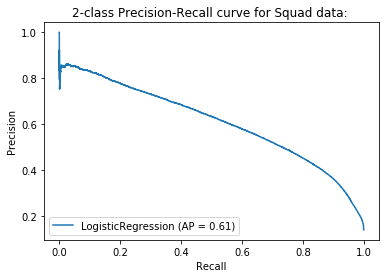

In [74]:
disp = plot_precision_recall_curve(squad_best_estimator, squad_xVal2, squad_yVal2)
disp.ax_.set_title('2-class Precision-Recall curve for Squad data: ')

### Evaluate Model Performance on Model Validation Data 

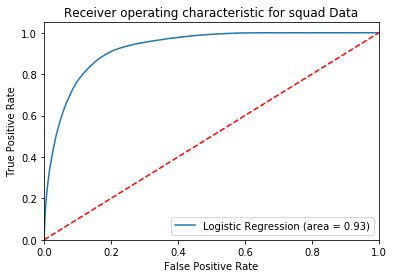

Accuracy of logistic regression classifier on validation set: 0.92
F1 of logistic regression classifier on model validation set: 0.51


/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Text(0.5, 1.0, '2-class Precision-Recall curve for squad data: ')

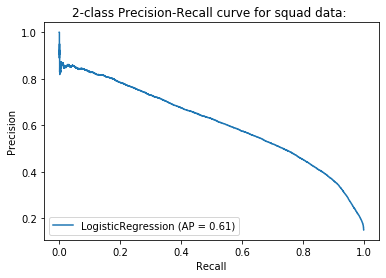

In [86]:
scaler = StandardScaler()

squad_xTrain2 = squad_train.copy().drop(columns ='y')
squad_yTrain2 = squad_train['y']
squad_xmodelVal = squad_modelVal.copy().drop(columns ='y')
squad_ymodelVal = squad_modelVal['y']

scaler.fit(squad_xTrain2)
squad_xTrain2 = scaler.transform(squad_xTrain2)
squad_xmodelVal = scaler.transform(squad_xmodelVal)

squad_best_estimator = grid_result.best_estimator_
estimator = squad_best_estimator
y_pred = estimator.predict_proba(squad_xmodelVal)
logit_roc_auc = roc_auc_score(squad_ymodelVal, y_pred[:,1])
fpr, tpr, thresholds = roc_curve(squad_ymodelVal, estimator.predict_proba(squad_xmodelVal)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for squad Data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

squad_best_estimator = grid_result.best_estimator_
squad_best_estimator.fit(squad_xTrain2,squad_yTrain2)
yHat = squad_best_estimator.predict(squad_xmodelVal)
print('Accuracy of logistic regression classifier on validation \
set: {:.2f}'.format(squad_best_estimator.score(squad_xmodelVal, squad_ymodelVal)))
print('F1 of logistic regression classifier on model validation set: {:.2f}'.format(f1_score(squad_ymodelVal, yHat)))

disp = plot_precision_recall_curve(squad_best_estimator, squad_xmodelVal, squad_ymodelVal)
disp.ax_.set_title('2-class Precision-Recall curve for squad data: ')

### Full Data 

#### Standard Scale
Since the dataset is too large, we use a sample of size 50000 to do the parameter tuning. \
Since we already took the sample in the feature engneering step, we will directly use the data sample: xTrain, yTrain

In [55]:
scaler = StandardScaler()

full_train = train.sample(n = 50000)
full_xTrain = full_train.copy().drop(columns ='y')
full_yTrain = full_train['y']

full_xTest = test.copy().drop(columns ='y')
full_yTest = test['y']

full_xVal = validation.copy().drop(columns ='y')
full_yVal = validation['y']

scaler.fit(full_xTrain)
full_xTrain2 = scaler.transform(full_xTrain)
full_xTest2 = scaler.transform(full_xTest)
full_xVal2 = scaler.transform(full_xVal)

In [57]:
# define dataset: squad_xTrain2_res, squad_yTrain2_res
# define models and parameters
model = LogisticRegression()
solver= ['lbfgs', 'sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid,
                           n_jobs=-1, cv=cv, verbose = 2, 
                           scoring='f1',error_score=0)
grid_result = grid_search.fit(full_xTrain2, full_yTrain)

Fitting 30 folds for each of 15 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  2.1min finished
/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [58]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, 
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.553196 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.553196 (0.014512) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.551443 (0.013758) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.550768 (0.014501) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.553011 (0.014558) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.551485 (0.013763) with: {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.550734 (0.014515) with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.552605 (0.014758) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.551485 (0.013555) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}
0.550477 (0.014370) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
0.550334 (0.015138) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.550546 (0.014936) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
0.549882 (0.015262) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
0.543576 (0.015599) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs

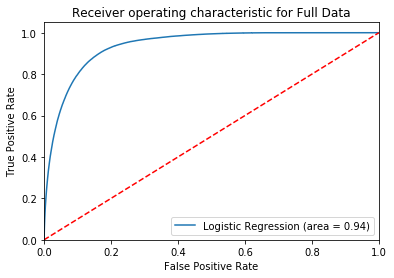

In [75]:
# estimator = grid_result.best_estimator_
estimator = full_best_estimator
y_pred = estimator.predict_proba(full_xVal2)
logit_roc_auc = roc_auc_score(full_yVal, y_pred[:,1])
fpr, tpr, thresholds = roc_curve(full_yVal, estimator.predict_proba(full_xVal2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Full Data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [78]:
# full_best_estimator = grid_result.best_estimator_
full_best_estimator.fit(full_xTrain2,full_yTrain)
yHat = squad_best_estimator.predict(full_xVal2)
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(full_best_estimator.score(full_xVal2, full_yVal)))
print('F1 of logistic regression classifier on validation set: {:.2f}'.format(f1_score(full_yVal, yHat)))

/Users/olivia_song/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of logistic regression classifier on validation set: 0.92
F1 of logistic regression classifier on validation set: 0.55


Text(0.5, 1.0, '2-class Precision-Recall curve for Full data: ')

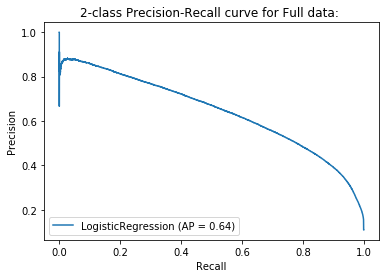

In [77]:
disp = plot_precision_recall_curve(full_best_estimator, full_xVal2, full_yVal)
disp.ax_.set_title('2-class Precision-Recall curve for Full data: ')